In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set(style="whitegrid")

# Load the datasets
# Training data: Contains only BENIGN traffic
df_train = pd.read_csv('Monday-WorkingHours.pcap_ISCX.csv')

# Testing data: Contains BENIGN and DoS attack traffic
df_test = pd.read_csv('Wednesday-workingHours.pcap_ISCX.csv')

print("Training data shape:", df_train.shape)
print("Testing data shape:", df_test.shape)

Training data shape: (529918, 85)
Testing data shape: (692703, 85)


In [3]:
# Strip leading/trailing spaces from column names
df_train.columns = df_train.columns.str.strip()
df_test.columns = df_test.columns.str.strip()

print("Cleaned column names.")

Cleaned column names.


In [4]:
# Replace infinite values with NaN
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [5]:
# Check for null values
print("Missing values in training data:\n", df_train.isnull().sum().sort_values(ascending=False).head())

# Drop rows with missing values
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

print("\nMissing values handled. New shapes:")
print("Training data shape:", df_train.shape)
print("Testing data shape:", df_test.shape)

Missing values in training data:
 Flow Bytes/s      437
Flow Packets/s    437
Source IP           0
Destination IP      0
Source Port         0
dtype: int64

Missing values handled. New shapes:
Training data shape: (529481, 85)
Testing data shape: (691406, 85)


In [6]:
# Check labels in the training data
print("Training Data Labels:\n", df_train['Label'].value_counts())

# Check labels in the testing data
print("\nTesting Data Labels:\n", df_test['Label'].value_counts())

Training Data Labels:
 Label
BENIGN    529481
Name: count, dtype: int64

Testing Data Labels:
 Label
BENIGN              439683
DoS Hulk            230124
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name: count, dtype: int64


In [7]:
# Simplify labels in the test set
df_test['Label'] = df_test['Label'].apply(lambda x: 'BENIGN' if x == 'BENIGN' else 'ATTACK')
print("\nSimplified Testing Data Labels:\n", df_test['Label'].value_counts())


Simplified Testing Data Labels:
 Label
BENIGN    439683
ATTACK    251723
Name: count, dtype: int64


count    5.294810e+05
mean     1.039785e+07
std      2.876227e+07
min     -1.000000e+00
25%      1.760000e+02
50%      3.131300e+04
75%      3.570680e+05
max      1.200000e+08
Name: Flow Duration, dtype: float64


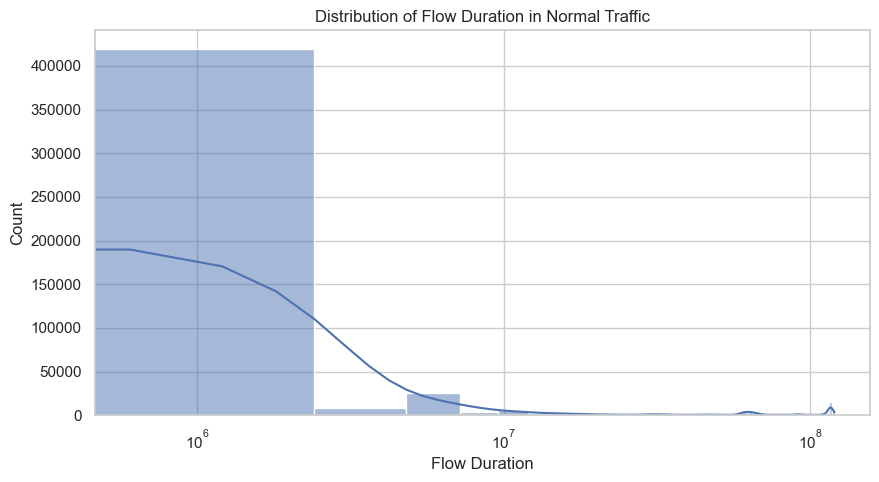

In [8]:
# Describe a key feature in the training data
print(df_train['Flow Duration'].describe())

# Plot its distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_train['Flow Duration'], bins=50, kde=True)
plt.title('Distribution of Flow Duration in Normal Traffic')
plt.xscale('log') # Use a log scale because the data is heavily skewed
plt.show()

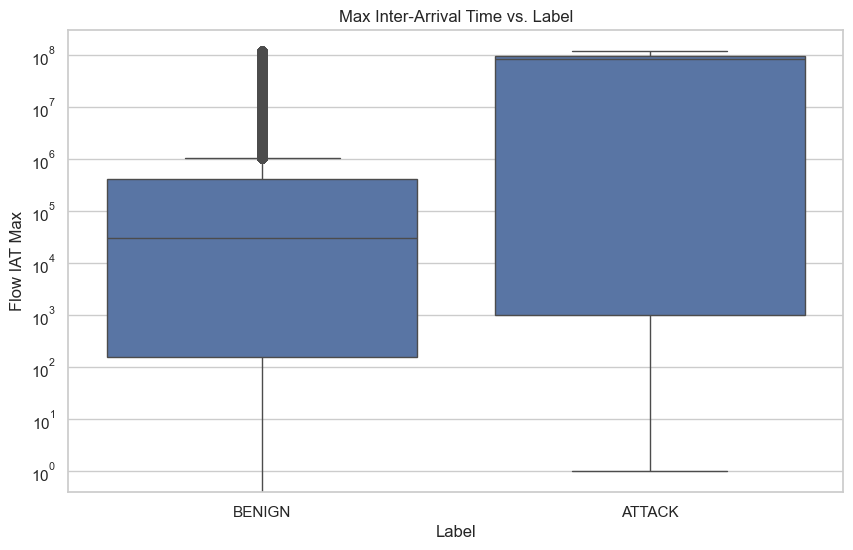

In [9]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label', y='Flow IAT Max', data=df_test)
plt.title('Max Inter-Arrival Time vs. Label')
plt.yscale('log') # Use a log scale to better visualize differences
plt.show()

In [10]:
# List of promising features to start with
selected_features = [
    'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
    'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max',
    'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Bwd Packet Length Max',
    'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow IAT Mean',
    'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Total',
    'Fwd PSH Flags', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count',
    'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count',
    'ECE Flag Count'
]

# Create the feature matrix 'X' and target vector 'y'
X_train = df_train[selected_features]
X_test = df_test[selected_features]
y_test = df_test['Label'] # We use this only for evaluating the model later

print("Data selected with", len(selected_features), "features.")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

Data selected with 25 features.
X_train shape: (529481, 25)
X_test shape: (691406, 25)


In [11]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler ONLY on the training data to learn the normal distribution
scaler.fit(X_train)

# Transform both the training and testing data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nData has been scaled.")


Data has been scaled.


In [21]:
from sklearn.ensemble import IsolationForest

# 1. Initialize the Isolation Forest model
#    n_jobs=-1 means it will use all available CPU cores to speed up training.
#    random_state=42 ensures you get the same results every time you run it.
#    contamination='auto' is a standard setting for the model to determine the anomaly threshold.
If_model = IsolationForest(n_jobs=-1, contamination='auto', random_state=42)

# 2. Train (fit) the model on the scaled, NORMAL training data
print("Training the Isolation Forest model...")
If_model.fit(X_train_scaled)
print("Model training complete.")

Training the Isolation Forest model...
Model training complete.


In [22]:
# 3. Get predictions on the test data
#    The model will analyze the mixed BENIGN/ATTACK traffic.
print("Making predictions on the test data...")
predictions = If_model.predict(X_test_scaled)

# The predict method returns 1 for inliers (normal) and -1 for outliers (anomalies).
# Let's map this to a more intuitive format: 0 for BENIGN, 1 for ATTACK.
# This makes it easier to compare with our true labels.
predictions_mapped = [1 if p == -1 else 0 for p in predictions]
print("Predictions are ready for evaluation.")

Making predictions on the test data...
Predictions are ready for evaluation.



==================== Model Evaluation ====================
Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.81      0.87      0.84    439683
      ATTACK       0.73      0.63      0.68    251723

    accuracy                           0.78    691406
   macro avg       0.77      0.75      0.76    691406
weighted avg       0.78      0.78      0.78    691406

Generating Confusion Matrix...


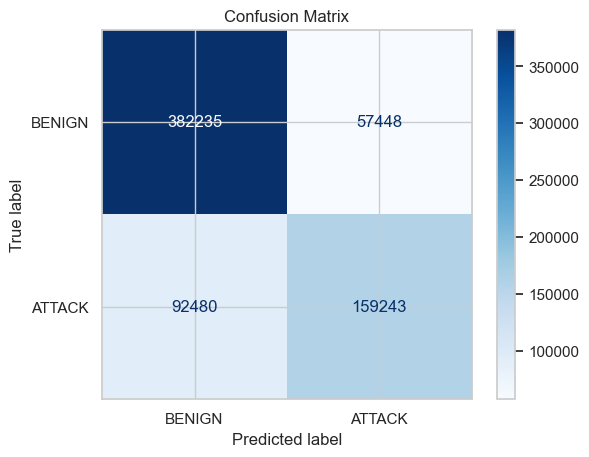

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# First, we map our true y_test labels to the same 0/1 format for a direct comparison.
y_test_mapped = y_test.apply(lambda x: 0 if x == 'BENIGN' else 1)

# 4. Generate and print the classification report
#    This shows key metrics like precision, recall, and f1-score.
print("\n" + "="*20 + " Model Evaluation " + "="*20)
report = classification_report(y_test_mapped, predictions_mapped, target_names=['BENIGN', 'ATTACK'])
print("Classification Report:")
print(report)

# 5. Generate and display the confusion matrix
#    This gives us a visual breakdown of correct vs. incorrect predictions.
print("Generating Confusion Matrix...")
cm = confusion_matrix(y_test_mapped, predictions_mapped)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['BENIGN', 'ATTACK'])

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [15]:
import numpy as np

# This function converts our 2D data into 3D sequences
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

# Define the length of the sequences
SEQUENCE_LENGTH = 10

# Reshape the training and testing data
# We now have sequences of 10 network flows
X_train_sequences = create_sequences(X_train_scaled, SEQUENCE_LENGTH)
X_test_sequences = create_sequences(X_test_scaled, SEQUENCE_LENGTH)

# We also need to adjust our test labels accordingly
y_test_sequences = y_test_mapped[SEQUENCE_LENGTH - 1:]

print("Training sequences shape:", X_train_sequences.shape)
print("Testing sequences shape:", X_test_sequences.shape)

Training sequences shape: (529472, 10, 25)
Testing sequences shape: (691397, 10, 25)


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

# Get the shape of the input data
n_features = X_train_sequences.shape[2]

# 1. Define the model
model = Sequential()
# Encoder
model.add(LSTM(64, activation='relu', input_shape=(SEQUENCE_LENGTH, n_features)))
model.add(RepeatVector(SEQUENCE_LENGTH)) # Repeats the compressed vector for the decoder
# Decoder
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features))) # Applies a Dense layer to each timestep

# 2. Compile the model
model.compile(optimizer='adam', loss='mae')
model.summary()

# 3. Train the model
print("\nTraining LSTM Autoencoder...")
history = model.fit(X_train_sequences, X_train_sequences,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1)
print("Training complete.")

c:\Users\Umesh eshwar reddy\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        23,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 25)         │         1,625 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,689 (225.35 KB)

 Trainable params: 57,689 (225.35 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM Autoencoder...
Epoch 1/20
14892/14892 ━━━━━━━━━━━━━━━━━━━━ 92s 6ms/step - loss: 0.1941 - val_loss: 0.0982
Epoch 2/20
14892/14892 ━━━━━━━━━━━━━━━━━━━━ 86s 6ms/step - loss: 0.0949 - val_loss: 0.0538
Epoch 3/20
14892/14892 ━━━━━━━━━━━━━━━━━━━━ 89s 6ms/step - loss: 0.0706 - val_loss: 0.0479
Epoch 4/20
14892/14892 ━━━━━━━━━━━━━━━━━━━━ 92s 6ms/step - loss: 0.0621 - val_loss: 0.0437
Epoch 5/20
14892/14892 ━━━━━━━━━━━━━━━━━━━━ 91s 6ms/step - loss: 0.0565 - val_loss: 0.0402
Epoch 6/20
14892/14892 ━━━━━━━━━━━━━━━━━━━━ 88s 6ms/step - loss: 0.0596 - val_loss: 0.0414
Epoch 7/20
14892/14892 ━━━━━━━━━━━━━━━━━━━━ 89s 6ms/step - loss: 0.0758 - val_loss: 0.0447
Epoch 8/20
14892/14892 ━━━━━━━━━━━━━━━━━━━━ 100s 7ms/step - loss: 0.0708 - val_loss: 0.0460
Epoch 9/20
14892/14892 ━━━━━━━━━━━━━━━━━━━━ 101s 7ms/step - loss: 0.0694 - val_loss: 0.0739
Epoch 10/20
14892/14892 ━━━━━━━━━━━━━━━━━━━━ 92s 6ms/step - loss: 0.0867 - val_loss: 0.0476
Epoch 11/20
14892/14892 ━━━━━━━━━━━━━━━━━━━━ 92s 6ms/step

In [17]:
import numpy as np

# Get the model's predictions (reconstructions)
X_train_pred = model.predict(X_train_sequences)
X_test_pred = model.predict(X_test_sequences)

# Calculate the MAE loss for each sequence
train_loss = np.mean(np.abs(X_train_pred - X_train_sequences), axis=(1, 2))
test_loss = np.mean(np.abs(X_test_pred - X_test_sequences), axis=(1, 2))

16546/16546 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step
21607/21607 ━━━━━━━━━━━━━━━━━━━━ 91s 4ms/step


In [18]:
# Set the threshold for what is considered an anomaly
threshold = np.mean(train_loss) + 3 * np.std(train_loss)
print("Anomaly threshold set to:", threshold)

Anomaly threshold set to: 0.8821541407954518



==================== LSTM Autoencoder Evaluation ====================
Classification Report:
              precision    recall  f1-score   support

      BENIGN       0.70      0.99      0.82    439674
      ATTACK       0.92      0.25      0.39    251723

    accuracy                           0.72    691397
   macro avg       0.81      0.62      0.60    691397
weighted avg       0.78      0.72      0.66    691397



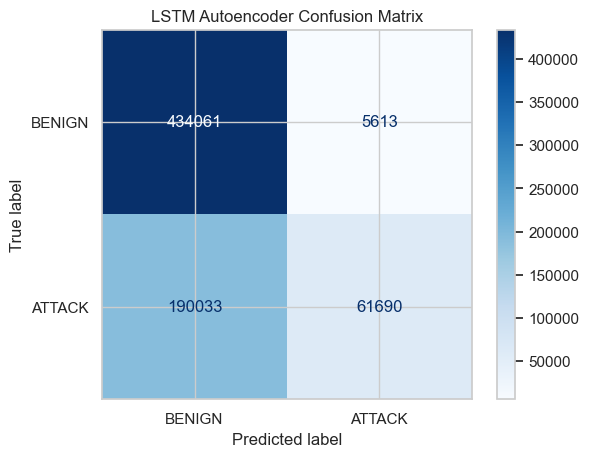

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get the final predictions by comparing the test loss to the threshold
lstm_preds = [1 if e > threshold else 0 for e in test_loss]

# Generate and print the report
print("\n" + "="*20 + " LSTM Autoencoder Evaluation " + "="*20)
report = classification_report(y_test_sequences, lstm_preds, target_names=['BENIGN', 'ATTACK'])
print("Classification Report:")
print(report)

# Generate and display the confusion matrix
cm = confusion_matrix(y_test_sequences, lstm_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['BENIGN', 'ATTACK'])

disp.plot(cmap=plt.cm.Blues)
plt.title('LSTM Autoencoder Confusion Matrix')
plt.show()

In [26]:
# Get the shape of your sequence data
n_samples, n_timesteps, n_features = X_test_sequences.shape

# 1. Reshape the 3D sequences into a 2D list of individual data points
# This will have a shape of (total_points, 25), which the model expects.
X_test_points_flat = X_test_sequences.reshape(-1, n_features)

# 2. Get anomaly scores for each individual point
# The output will be one long list of scores.
point_scores = -1 * If_model.score_samples(X_test_points_flat)

# 3. Reshape the scores back into a sequence format (samples, timesteps)
sequence_scores = point_scores.reshape(n_samples, n_timesteps)

# 4. Aggregate the scores for each sequence by taking the mean
# This gives us one final score per sequence.
if_scores = np.mean(sequence_scores, axis=1)

# Now 'if_scores' is ready to be used.
# The rest of your code for getting lstm_scores and combining them will work correctly.
print("Successfully generated scores from the Isolation Forest model.")

Successfully generated scores from the Isolation Forest model.


In [27]:
import numpy as np

# 1. Use your trained LSTM model to get reconstructions of the test data
test_reconstructions = model.predict(X_test_sequences)

# 2. Calculate the Mean Absolute Error (MAE) for each sequence.
# This error IS your anomaly score.
lstm_scores = np.mean(np.abs(test_reconstructions - X_test_sequences), axis=(1, 2))

print("Successfully calculated lstm_scores.")

21607/21607 ━━━━━━━━━━━━━━━━━━━━ 105s 5ms/step
Successfully calculated lstm_scores.


In [28]:
from sklearn.preprocessing import MinMaxScaler

# 1. Initialize two separate scalers, one for each model's scores.
scaler_if = MinMaxScaler()
scaler_lstm = MinMaxScaler()

# 2. Reshape the 1D score arrays into 2D arrays, which the scaler expects.
if_scores_reshaped = if_scores.reshape(-1, 1)
lstm_scores_reshaped = lstm_scores.reshape(-1, 1)

# 3. Fit and transform each set of scores to scale them between 0 and 1.
if_scores_scaled = scaler_if.fit_transform(if_scores_reshaped)
lstm_scores_scaled = scaler_lstm.fit_transform(lstm_scores_reshaped)

print("Scores from both models have been successfully normalized.")

Scores from both models have been successfully normalized.


In [30]:
# Define weights for each model's score
weight_if = 0.5
weight_lstm = 0.5

# Calculate the final hybrid score
hybrid_score = (weight_if * if_scores_scaled) + (weight_lstm * lstm_scores_scaled)
print(hybrid_score)

[[0.16403192]
 [0.17142914]
 [0.21018655]
 ...
 [0.07538243]
 [0.071617  ]
 [0.0697652 ]]


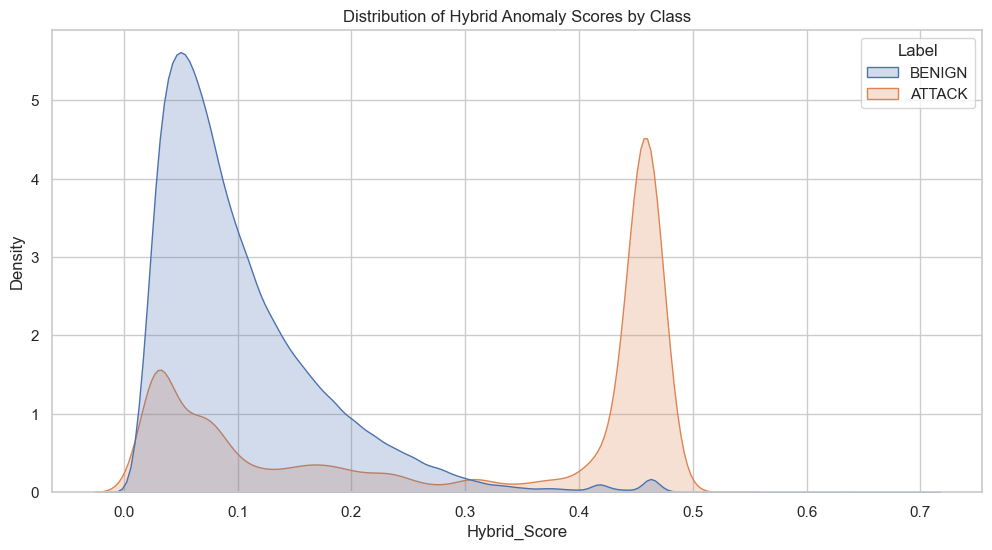

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for easy plotting
results_df = pd.DataFrame({
    'True_Label': y_test_sequences,
    'Hybrid_Score': hybrid_score.flatten()
})

# Map the numeric labels back to strings for the legend
results_df['Label'] = results_df['True_Label'].apply(lambda x: 'ATTACK' if x == 1 else 'BENIGN')

# Plot the distributions
plt.figure(figsize=(12, 6))
sns.kdeplot(data=results_df, x='Hybrid_Score', hue='Label', fill=True)
plt.title('Distribution of Hybrid Anomaly Scores by Class')
plt.show()


==================== New Hybrid Model Evaluation ====================
              precision    recall  f1-score   support

      BENIGN       0.81      0.90      0.85    439674
      ATTACK       0.78      0.63      0.70    251723

    accuracy                           0.80    691397
   macro avg       0.80      0.77      0.78    691397
weighted avg       0.80      0.80      0.80    691397



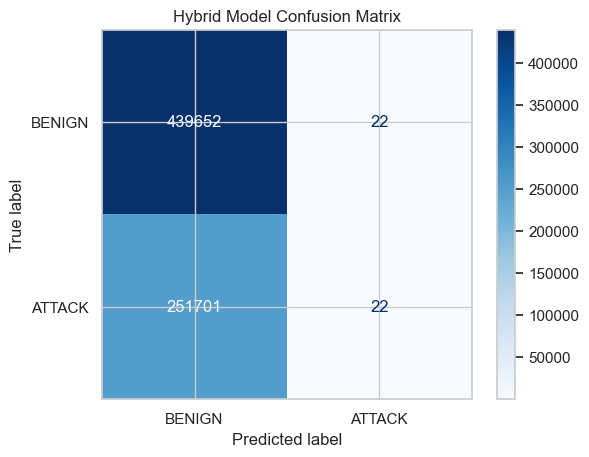

In [35]:
# Try a new, lower threshold based on your plot
new_threshold = 0.2 # <--- CHANGE THIS VALUE BASED ON YOUR PLOT

# Get new predictions using the new threshold
new_preds = [1 if s > new_threshold else 0 for s in hybrid_score]

# Generate and print the new classification report
print("\n" + "="*20 + " New Hybrid Model Evaluation " + "="*20)
new_report = classification_report(y_test_sequences, new_preds, target_names=['BENIGN', 'ATTACK'])
print(new_report)
# Generate and display the confusion matrix
cm = confusion_matrix(y_test_sequences, hybrid_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['BENIGN', 'ATTACK'])

disp.plot(cmap=plt.cm.Blues)
plt.title('Hybrid Model Confusion Matrix')
plt.show()

In [36]:
import joblib
from tensorflow.keras.models import load_model

# --- 1. Save the trained models ---
# Save the Isolation Forest model
joblib.dump(If_model, 'if_model.pkl')
print("Isolation Forest model saved to 'if_model.pkl'")

# Save the LSTM Autoencoder model
model.save('lstm_model.h5')
print("LSTM model saved to 'lstm_model.h5'")


# --- 2. Save the scalers ---
# Save the main data scaler
joblib.dump(scaler, 'data_scaler.pkl')
print("Data scaler saved to 'data_scaler.pkl'")

# Save the scalers used to normalize the anomaly scores
joblib.dump(scaler_if, 'if_score_scaler.pkl')
joblib.dump(scaler_lstm, 'lstm_score_scaler.pkl')
print("Score scalers saved.")


# --- 3. Note down your final parameters ---
OPTIMAL_HYBRID_THRESHOLD = 0.2 # The best threshold you found
WEIGHT_IF = 0.5
WEIGHT_LSTM = 0.5
print(f"Final parameters recorded. Threshold: {OPTIMAL_HYBRID_THRESHOLD}")

Isolation Forest model saved to 'if_model.pkl'
LSTM model saved to 'lstm_model.h5'
Data scaler saved to 'data_scaler.pkl'
Score scalers saved.
Final parameters recorded. Threshold: 0.2
